# Analyze barcode correlation between replicates
Samples from the 2-24-22 run included both infection replicates and RT replicates. This notebook generates scatterplots showing pairwise correlation between barcode counts from different runs. Plots are saved in `scratch_figs/`

In [1]:
import os

import altair as alt

import Bio.SeqIO

import dms_variants.codonvarianttable
import dms_variants.utils
import dms_variants.plotnine_themes

import scipy.stats

import pandas as pd

import yaml

from plotnine import *
_ = theme_set(dms_variants.plotnine_themes.theme_graygrid())

In [2]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

Change working directory to top directory of repo:

In [3]:
os.chdir('../../')

Read configuration:

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read the barcode counts and barcode runs:

In [5]:
barcode_runs = (
    pd.read_csv(config["barcode_runs"])
    .assign(antibody=lambda x: x["antibody"].fillna("no antibody"))
)

barcode_counts = pd.read_csv(config["barcode_counts"])

Read the parental gene sequence:

In [6]:
geneseq = str(Bio.SeqIO.read(config['gene_sequence_codon'], 'fasta').seq)
assert len(geneseq) % 3 == 0

Get the primary target:

In [7]:
primary_target = config["gene"]

## General Data Setup

Create a [dms_variants codon-variant table](https://jbloomlab.github.io/dms_variants/codonvariant_sim_data.html):

In [8]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
    barcode_variant_file=config["virus_variants_w_neut_standard"],
    geneseq=geneseq,
    substitutions_are_codon=True,
    substitutions_col="codon_substitutions",
    allowgaps=True,
    primary_target=config["gene"],
)

Now add the sample counts:

In [9]:
variants.add_sample_counts_df(barcode_counts)

In [10]:
variant_counts = (
    variants.variant_count_df
    .query("target == @primary_target")
    [["library", "sample", "barcode", "count", "aa_substitutions"]]
    .merge(barcode_runs.drop(columns=["fastq_R1", "notes", "antibody_concentration"]))
    .assign(percent=lambda x: 100 * x["count"] / x.groupby("library_sample")["count"].transform("sum"))
    .sort_values(["library", "sample", "count"], ascending=[True, True, False])
)

Reduce dataframe to just samples from 2-24-22, and simplify names for clearer analysis

In [11]:
reformatted_variants = variant_counts.drop(columns='library')
reformatted_variants['date'] = reformatted_variants['sample'].str.split('_').str[0]

short_names = {
    '220224_1_antibody_AUSAB-07_0.000158_1_rt1': 'serum-IC65_1_RT-1',
    '220224_1_antibody_AUSAB-07_0.000158_1_rt2': 'serum-IC65_1_RT-2',
    '220224_1_antibody_AUSAB-07_0.000158_2': 'serum-IC65_2',
    '220224_1_antibody_AUSAB-07_0.00632_1': 'serum-IC99.90_1',
    '220224_1_antibody_AUSAB-07_0.00632_2': 'serum-IC99.90_2',
    '220224_1_antibody_AUSAB-07_0.0158_1': 'serum-IC99.99_1',
    '220224_1_antibody_AUSAB-07_0.0158_2_rt1': 'serum-IC99.99_2_RT-1',
    '220224_1_antibody_AUSAB-07_0.0158_2_rt2': 'serum-IC99.99_2_RT-2',
    '220224_1_no-antibody_control_670ng_1': 'no-Ab_1',
    '220224_1_no-antibody_control_670ng_2': 'no-Ab_2'
}

reformatted_variants['sample'] = reformatted_variants['sample'].map(short_names)
reformatted_variants = reformatted_variants.dropna()    

In [12]:
# add condition column for grouping
reformatted_variants['condition'] = reformatted_variants['sample'].str.split('_').str[0]

# make a specific edit to replicate -
reformatted_variants['replicate'].loc[(reformatted_variants['replicate'] == '670ng_1')] = '1'
reformatted_variants['replicate'].loc[(reformatted_variants['replicate'] == '670ng_2')] = '2'

reformatted_variants.head()

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sample,barcode,count,aa_substitutions,date,virus_batch,sample_type,antibody,replicate,library_sample,percent,condition
959340,serum-IC65_1_RT-1,ATAACACAAAAAAGTA,55740,K297I,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,2.945222,serum-IC65
959341,serum-IC65_1_RT-1,AGACACTAAATACAGC,15854,Y113N T150K L263H V342Y,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.837703,serum-IC65
959342,serum-IC65_1_RT-1,AAACATAAATGGACTA,15472,K190H T347D L386K D457H,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.817518,serum-IC65
959343,serum-IC65_1_RT-1,TACAGGTTCAACTAAT,13389,G24F T206A L263S W536L,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.707456,serum-IC65
959344,serum-IC65_1_RT-1,AAAAATCTGAGACAAA,12619,K46A I301V E409M,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.666770,serum-IC65


Previous analysis indicated that a single outlier dominated variant counts, making up ~3% of the library variants. Remove this single outlier to avoid skewing visualizations:

In [13]:
drop_top_n = 1

reformatted_variants = (reformatted_variants
                             .sort_values(["count"], ascending=[False])
                             .groupby('library_sample')
                             .apply(lambda group: group.iloc[drop_top_n:])
                            )

## Generate Correlation Scatterplots

Define functions that will: 
* generate tidy, plottable dataframes of barcode counts for replicates of interest
* plot correlations between these replicates and label with r2 from linear regression

In [14]:
def pivot_counts(df, condition):
    counts_by_condition = (
        df.loc[df['condition'] == condition]
        .pivot(index='barcode', columns='sample', values='count')
        .reset_index()
        .rename_axis(None, axis=1)
    )
    
    return counts_by_condition


def plot_correlates(df, condition, replicate_pairs, figs_dir):
    
    for pair in replicate_pairs:
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            df[f'{condition}_{pair[0]}'], df[f'{condition}_{pair[1]}'])
        
        r2 = r_value**2

        p = (
            ggplot(
            df,
            aes(x=f'{condition}_{pair[0]}', y=f'{condition}_{pair[1]}')) + 
        geom_point() + 
        annotate('text', 
                 x=((df[f'{condition}_{pair[0]}'].max())*0.16), 
                 y=((df[f'{condition}_{pair[1]}'].max())*0.9), 
                 label=f'r2={str(r2)[0:5]}', size=10) +
        theme(figure_size=(3, 3),
             panel_grid_major_x=element_blank(),
             ))
        
        plotfile = os.path.join(figs_dir, f"{condition}_{pair[0]}_{pair[1]}_corr.png")
        print(f'saving plot to {plotfile}')
        p.save(plotfile, verbose=False)

        _ = p.draw()
        

*Note on following code - I ended up doing this roughly, because each serum selection condition had slightly different replicate labels. Since this was a one-off analysis, I didn't take the time to clean up the naming / code. See `scratch_figs/220224_correlations/` for full set of correlation scatterplots.*

saving plot to scratch_notebooks/220303_summary_figures/scratch_figs/220224_correlations/serum-IC99.99_2_RT-1_2_RT-2_corr.png
saving plot to scratch_notebooks/220303_summary_figures/scratch_figs/220224_correlations/serum-IC99.99_2_RT-1_1_corr.png


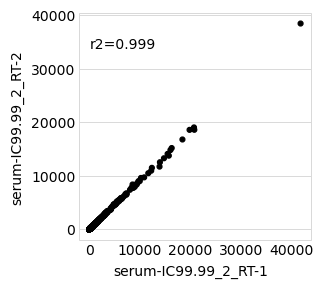

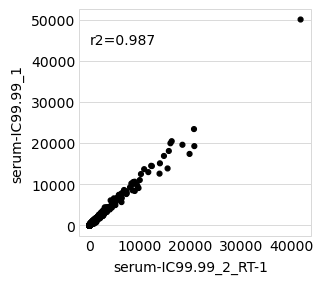

In [15]:
figs_dir = 'scratch_notebooks/220303_summary_figures/scratch_figs/220224_correlations'
conditions = ['serum-IC99.99']
replicate_pairs = [['2_RT-1','2_RT-2'], ['2_RT-1', '1']]
# replicate_pairs = [['1', '2']]

for coverage in conditions:
    counts_by_replicate = pivot_counts(reformatted_variants, coverage)
    plot_correlates(counts_by_replicate, coverage, replicate_pairs, figs_dir)

## Analyze number of unique variants in each condition
One last plot - just see how many unique variants show up for each antibody selection condition, if we remove everything that had 0 counts

In [16]:
# edit names for virus meeting, drop to just 220224 samples

rep_variants = variant_counts.drop(columns='library')
# reformatted_variants['date'] = reformatted_variants['sample'].str.split('_').str[0]

short_names = {
#     '220121_1_no-antibody_control_50x_1': 'no-Ab_1',
#     '220121_1_no-antibody_control_50x_2_rt1': 'no-Ab_2_RT-1',
#     '220121_1_no-antibody_control_50x_2_rt2': 'no-Ab_2_RT-2',
    '220224_1_antibody_AUSAB-07_0.000158_1_rt1': 'serum-IC65.00',
#     '220224_1_antibody_AUSAB-07_0.000158_1_rt2': 'serum-IC65_1_RT-2',
#     '220224_1_antibody_AUSAB-07_0.000158_2': 'serum-IC65_2',
    '220224_1_antibody_AUSAB-07_0.000395_1': 'serum-IC90.00',
#     '220224_1_antibody_AUSAB-07_0.000395_2': 'serum-IC90_2',
    '220224_1_antibody_AUSAB-07_0.00158_1': 'serum-IC99.00',
#     '220224_1_antibody_AUSAB-07_0.00158_2': 'serum-IC99_2',
    '220224_1_antibody_AUSAB-07_0.00632_1': 'serum-IC99.90',
#     '220224_1_antibody_AUSAB-07_0.00632_2': 'serum-IC99.90_2',
    '220224_1_antibody_AUSAB-07_0.0158_1': 'serum-IC99.99',
#     '220224_1_antibody_AUSAB-07_0.0158_2_rt1': 'serum-IC99.99_2_RT-1',
#     '220224_1_antibody_AUSAB-07_0.0158_2_rt2': 'serum-IC99.99_2_RT-2',
    '220224_1_no-antibody_control_670ng_1': 'no-Ab',
#     '220224_1_no-antibody_control_670ng_2': 'no-Ab_2',
    '220224_1_no-antibody_control_plasmid': 'plasmid'
}


rep_variants['sample'] = rep_variants['sample'].map(short_names)
rep_variants = rep_variants.dropna(subset=['sample'])

rep_variants.head()

,sample,barcode,count,aa_substitutions,date,virus_batch,sample_type,antibody,replicate,library_sample,percent
959340,serum-IC65.00,ATAACACAAAAAAGTA,55740,K297I,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,2.945222
959341,serum-IC65.00,AGACACTAAATACAGC,15854,Y113N T150K L263H V342Y,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.837703
959342,serum-IC65.00,AAACATAAATGGACTA,15472,K190H T347D L386K D457H,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.817518
959343,serum-IC65.00,TACAGGTTCAACTAAT,13389,G24F T206A L263S W536L,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.707456
959344,serum-IC65.00,AAAAATCTGAGACAAA,12619,K46A I301V E409M,220224,1,antibody,AUSAB-07,1_rt1,libA_220224_1_antibody_AUSAB-07_0.000158_1_rt1,0.666770


In [17]:
variants_seen = rep_variants.loc[rep_variants['count'] != 0]
variants_seen = variants_seen.groupby(['sample']).size().reset_index(name='unique_variants')
variants_seen['color'] = ['#999999', '#999999', '#FEC44F', '#FB9A29', '#EC7014', '#CC4C02', '#993404']

In [20]:
# mutation_type_selection = alt.selection_multi(fields=["mutation_type"], bind="legend")

avg_muts_chart = (
    alt.Chart(
        variants_seen
                        )
    .encode(
        x=alt.X(
            "unique_variants",
            title="unique variants sequenced",
            axis=alt.Axis(grid=False),
        ),
        y=alt.Y(
            "sample",
            title=None,
            sort=['plasmid', 'no-Ab']
        ),
        color=alt.Color('color', scale = None)
#         color=alt.Color(
#             "mutation_type",
#             scale=alt.Scale(domain=mut_types_sort),
#         ),
#         order=alt.Order("order", sort="descending"),
#         tooltip=[alt.Tooltip(c, format=".3g") if c in ["count", "number"] else c
#                  for c in avg_muts.columns if c != "sample"],
    )
    .mark_bar()
    .properties(height=alt.Step(13), width=300)
    .configure_axis(labelLimit=500)
#     .add_selection(mutation_type_selection, *selections)
#     .transform_filter(mutation_type_selection)
)

# for selection in selections:
#     avg_muts_chart = avg_muts_chart.transform_filter(selection)

avg_muts_chart.save('scratch_notebooks/220303_summary_figures/scratch_figs/unique_variants.pdf')

avg_muts_chart

alt.Chart(...)